In [14]:
import requests
import json
import lxml.html as lh
import pandas as pd

from bs4 import BeautifulSoup as bs

In [22]:
ft_url = 'http://markets.ft.com'

In [63]:
# Quesry FT symbol by ISIN on web

def query_ft_ticker( isin_ticker ):
    
    r = requests.get( ft_url + '/data/search', params = {'query':isin_ticker})
    
    if r.status_code == requests.codes.ok:
        soup = bs(r.text, "html.parser")
        tb = soup.find('table', class_='mod-ui-table mod-ui-table--freeze-pane')      
        tr = tb.findAll('tr')
                
        if len(tr)!= 1:
            return
        
        td = tr[0].find('td')
        href = td.find('a').get('href')
        name = td.text
        
        print(href)
        print(name)
        
        td = td.find_next_sibling()
        symbol = td.text
        print(symbol)
    
        r = requests.get(ft_url + href)
        #print(r.url)
        if r.status_code == requests.codes.ok:
            soup = bs(r.text, "html.parser")
            
            k = soup.find('section', class_='mod-tearsheet-add-to-watchlist')
            js = json.loads(str(k.get('data-mod-config')))
            
            xid = js['xid']
            print(xid)
    
            return xid
    return


In [76]:
# Get Fund historical prices from markets.ft.com

def get_historical_prices( isin_ticker, fromDate='2018/01/01', toDate='2018/11/27' ):   
    
    q_params = {'startDate': fromDate,
                'endDate': toDate,
                'symbol': query_ft_ticker(isin_ticker)}

    # Download the result from website
    r = requests.get( ft_url + '/data/equities/ajax/get-historical-prices', params = q_params)
    #print(r.url)

    # Check if it is ok
    if r.status_code == requests.codes.ok:

        # Prepare table and headers
        headers = ["Date", "Open", "High", "Low", "Close", "Volume"]
        col = []
        for h in headers:
            col.append((h,[]))

        #Store the contents of the website under doc
        doc = lh.fromstring(r.json()['html'])
    
        #Parse data that are stored between <tr>..</tr> of HTML
        tr_elements = doc.xpath('//tr')
    
        #Since out first row is the header, data is stored on the second row onwards
        for e in tr_elements:
            #If row is not of size 6, the //tr data is not from our table 
            if len(e)!=6:
                break
    
            #i is the index of our column
            i=0
    
            #Iterate through each element of the row
            for t in e.iterchildren():
         
                if i==0:
                    data=t[1].text_content()
                else:
                    data=t.text_content() 
                
                #Append the data to the empty list of the i'th column
                col[i][1].append(data)
        
                #Increment i for the next column
                i+=1

        return {title:column for (title,column) in col}   


In [84]:
df = pd.DataFrame(get_historical_prices('INX:IOM',fromDate='2015/01/01',toDate='2018/12/31'))

df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = pd.to_numeric(df['Open'].replace({',':''},regex=True))
df['High'] = pd.to_numeric(df['High'].replace({',':''},regex=True))
df['Low'] = pd.to_numeric(df['Low'].replace({',':''},regex=True))
df['Close'] = pd.to_numeric(df['Close'].replace({',':''},regex=True))


/data/indices/tearsheet/summary?s=INX:IOM
S&P 500 INDEX
INX:IOM
575769


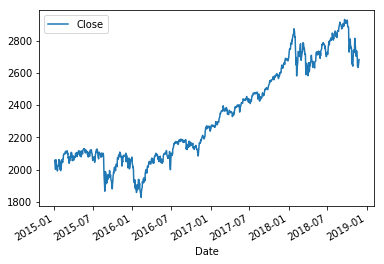

In [87]:
df.plot(x='Date',y='Close')

In [86]:
df

,Date,Open,High,Low,Close,Volume
0,2018-11-27,2663.75,2682.53,2655.89,2682.17,"2,164,784,0002.16bn"
1,2018-11-26,2649.97,2674.35,2649.97,2673.45,"2,223,764,0002.22bn"
2,2018-11-23,2633.36,2647.55,2631.09,2632.56,"996,601,000996.60m"
3,2018-11-21,2657.74,2670.73,2649.82,2649.93,"2,052,551,0002.05bn"
4,2018-11-20,2654.60,2669.44,2631.52,2641.89,"2,887,816,0002.89bn"
5,2018-11-19,2730.74,2733.16,2681.09,2690.73,"2,528,464,0002.53bn"
6,2018-11-16,2718.54,2746.75,2712.16,2736.27,"2,693,967,0002.69bn"
7,2018-11-15,2693.52,2735.38,2670.75,2730.20,"2,723,522,0002.72bn"
8,2018-11-14,2737.90,2746.80,2685.75,2701.58,"2,669,620,0002.67bn"
9,2018-11-13,2730.05,2754.60,2714.98,2722.18,"2,355,351,0002.36bn"
